In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 
import prob_new as p
from aps_annealing import *
from time_mc import *
from mcmc import *
from joblib import Parallel, delayed
import multiprocessing
import sys
import pickle
import argparse
from timeit import default_timer
from importlib import import_module
from contextlib import contextmanager
from plotnine import *

# Monte Carlo

Fix a discretization step

In [137]:
stepA = 0.1
stepD = 0.1
##
a_values = np.arange(0, 1, stepA)
d_values = np.arange(0, 1, stepD)

Compute ground truth

In [35]:
d_true = mcmc_adg(d_values, a_values, p.d_util, p.a_util, p.prob, p.prob,
             mcmc_iters=100000, info=False)

KeyboardInterrupt: 

In [ ]:
d_true

In [10]:
def optimal_number_iters(d_values, a_values, d_true, times=50, n_jobs=-1):

    iters = np.arange(1000, 10000000, 1000)

    for i in iters:
        def find_d_opt_MC(j):
            d_opt = mcmc_adg(d_values, a_values, p.d_util, p.a_util, p.prob, 
                             p.prob, mcmc_iters=i, info=False)
            return d_opt

        optimal_d = Parallel(n_jobs=n_jobs)(
            delayed(find_d_opt_MC)(j) for j in range(times)
        )

        percent = np.mean(np.array(optimal_d) == d_true)
        print(percent)
        ## Are 90% equal to the truth? Then we converge.
        if percent >= 0.9:
            break

    return i

In [11]:
optimal_number_iters(d_values, a_values, d_true, times=50, n_jobs=-1)
# numpy.isclose(a, b, rtol=1e-05, atol=1e-08, equal_nan=False)


0.26


KeyboardInterrupt: 

In [15]:
iters = np.arange(1000, 10000000, 1000)
n_jobs = -1
times = 50
i = 1000
def find_d_opt_MC(j):
    d_opt = mcmc_adg(d_values, a_values, p.d_util, p.a_util, p.prob, 
                     p.prob, mcmc_iters=i, info=False)
    return d_opt

optimal_d = Parallel(n_jobs=n_jobs)(
    delayed(find_d_opt_MC)(j) for j in range(times)
)

percent = np.mean(np.array(optimal_d) == d_true)
print(percent)


0.24


In [62]:
d_opt, p_a, psi_d, psi_a, times = mcmc_adg(d_values, a_values, p.d_util, p.a_util, p.prob, p.prob,
                                           mcmc_iters=10000, info=True)

In [63]:
psi_d = pd.DataFrame({"d": d_values, "EU": psi_d})

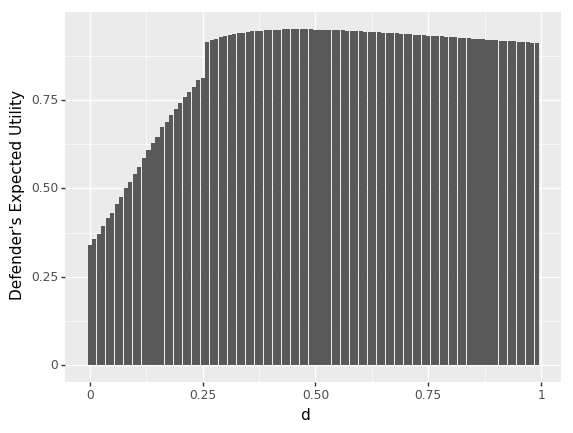

<ggplot: (8747899391587)>

In [74]:
p = ggplot(psi_d, aes(x = "d", y = "EU")) + geom_bar(stat="identity")
p = p + ylab("Defender's Expected Utility")
p

In [76]:
p.save("Test.eps", format="eps")

/home/roi/.local/lib/python3.6/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units))
/home/roi/.local/lib/python3.6/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: Test.eps
  warn('Filename: {}'.format(filename))


## Compute minimum required number of iteratios to converge

In [77]:
iters = np.arange(1000, 100000, 1000)
optimal_d = []
##
mylist = np.arange(50)
##
for i in iters:
    ## Run 50 different processes
    num_cores = multiprocessing.cpu_count()
    ##
    def find_d_opt_MC(j):
        d_opt = mcmc_adg(d_values, a_values, p.d_util, p.a_util, p.prob, p.prob,
                 mcmc_iters=i, info=False)
        return d_opt
    ##
    optimal_d = np.asarray( Parallel(n_jobs=num_cores)(delayed(find_d_opt_MC)(j) for j in mylist) )
    ##
    ## Are all equal to the truth? Then we converge.
    if np.all(optimal_d == d_true):
        n_opt_iters = i
        break
    

## Measure time

In [99]:
@contextmanager
def timer():
    start = default_timer()
    try:
        yield
    finally:
        end = default_timer()
        print("Elapsed time (s): {:.6f}".format(end - start))
        return(end - start)
        #print("Elapsed time (s): {:.6f}".format(end - start))


In [100]:
start = default_timer()
##
d_opt = mcmc_adg(d_values, a_values, p.d_util, p.a_util, p.prob, p.prob,
        mcmc_iters=n_opt_iters, info=False)
##
end = default_timer()

Elapsed time (s): 0.088151


In [148]:
mcmc_adg(d_values, a_values, p.d_util, p.a_util, p.prob, p.prob,
        1000, info=False)

0.5

# Augmented Probability Simulation

## Attacker's APS for given decision

In [2]:
a_opt, a_d = innerAPS(1000, 0.1, a_util, prob, N_inner=1000, mean=False, burnin=0.1, prec = 0.01,
    info=True)

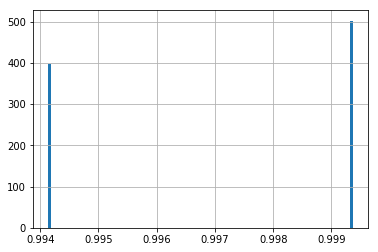

In [3]:
a_d.hist(bins = int(1.0/0.01))
plt.show()

In [4]:
a_opt

0.9993389066740833

## Defender's APS

In [118]:
d_opt, d_d = aps_adg_ann(1000, 1000, d_util, a_util, prob, N_aps=10, burnin=0.1, N_inner=10, prec=0.01, mean=True, 
                     info=True)

In [119]:
d_opt

0.487044714639014

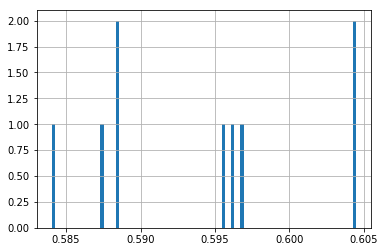

In [91]:
d_d.hist(bins = int(1.0/0.01))
plt.show()

In [31]:
start = default_timer()
##
d_opt = aps_adg_ann(100000, 1000, d_util, a_util, prob, N_aps=1000, burnin=0.1, N_inner=100, prec=0.01, mean=True, 
                     info=False)
##
end = default_timer()
end - start

64.36520635895431

In [128]:
times = []
for i in range(100):
    start = default_timer()
    ##
    d_opt = aps_adg_ann(100000, 1000, d_util, a_util, prob, N_aps=1000, burnin=0.1, N_inner=100, prec=0.01, mean=True, 
                     info=False)
    ##
    end = default_timer()
    times.append(end - start)

